In [1]:
!pip install tensorflow==2.1.0

     |████████████████████████████████| 421.8MB 37kB/s 
     |████████████████████████████████| 3.9MB 49.3MB/s 
     |████████████████████████████████| 450kB 42.4MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=391ac2cb043164c794263a1080ff6dbf472c17acc90335cefa9856059c6de408
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.10.0 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: tensorboard 2.2.2
    Uninstalling tensorboard-2.2.2:
      Successfully uninstalled tensorboard-2.2.2
  Found existing installation: tensorflow-estimator 2.2.0
    Uninstalling tensorflow-estimator-2.2.0:
      Successfully uninstalled tensorflow-estimator-2.2.0
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
  Found existing installation: 

In [2]:
!pip install tensorflow-quantum

In [0]:
import tensorflow as tf
import tensorflow_quantum as tfq

import cirq
import sympy
import numpy as np

# visualization tools
%matplotlib inline
import matplotlib.pyplot as plt
from cirq.contrib.svg import SVGCircuit

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


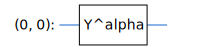

In [4]:
qubit = cirq.GridQubit(0, 0)
my_circuit = cirq.Circuit(cirq.Y(qubit)**sympy.Symbol('alpha'))
SVGCircuit(my_circuit)

In [5]:
pauli_x = cirq.X(qubit)
pauli_x

X((0, 0))

In [6]:
def my_expectation(op, alpha):
    """Compute ⟨Y(alpha)| `op` | Y(alpha)⟩"""
    params = {'alpha': alpha}
    sim = cirq.Simulator()
    final_state = sim.simulate(my_circuit, params).final_state
    return op.expectation_from_wavefunction(final_state, {qubit: 0}).real


my_alpha = 0.3
print("Expectation=", my_expectation(pauli_x, my_alpha))
print("Sin Formula=", np.sin(np.pi * my_alpha))

Expectation= 0.80901700258255
Sin Formula= 0.8090169943749475


In [7]:
def my_grad(obs, alpha, eps=0.01):
    grad = 0
    f_x = my_expectation(obs, alpha)
    f_x_prime = my_expectation(obs, alpha + eps)
    return ((f_x_prime - f_x) / eps).real


print('Finite difference:', my_grad(pauli_x, my_alpha))
print('Cosine formula:   ', np.pi * np.cos(np.pi * my_alpha))

Finite difference: 1.8063604831695557
Cosine formula:    1.8465818304904567


In [8]:
expectation_calculation = tfq.layers.Expectation(
    differentiator=tfq.differentiators.ForwardDifference(grid_spacing=0.01))

expectation_calculation(my_circuit,
                        operators=pauli_x,
                        symbol_names=['alpha'],
                        symbol_values=[[my_alpha]])

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.8090171]], dtype=float32)>

In [9]:
sampled_expectation_calculation = tfq.layers.SampledExpectation(
    differentiator=tfq.differentiators.ForwardDifference(grid_spacing=0.01))

sampled_expectation_calculation(my_circuit,
                                operators=pauli_x,
                                repetitions=500,
                                symbol_names=['alpha'],
                                symbol_values=[[my_alpha]])

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.808]], dtype=float32)>

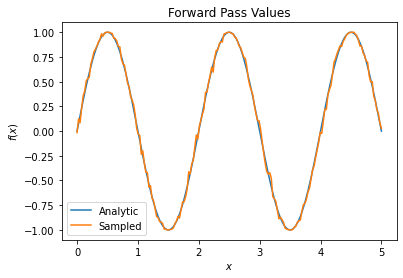

In [10]:
# Make input_points = [batch_size, 1] array.
input_points = np.linspace(0, 5, 200)[:, np.newaxis].astype(np.float32)
exact_outputs = expectation_calculation(my_circuit,
                                        operators=pauli_x,
                                        symbol_names=['alpha'],
                                        symbol_values=input_points)
imperfect_outputs = sampled_expectation_calculation(my_circuit,
                                                    operators=pauli_x,
                                                    repetitions=500,
                                                    symbol_names=['alpha'],
                                                    symbol_values=input_points)
plt.title('Forward Pass Values')
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.plot(input_points, exact_outputs, label='Analytic')
plt.plot(input_points, imperfect_outputs, label='Sampled')
plt.legend()

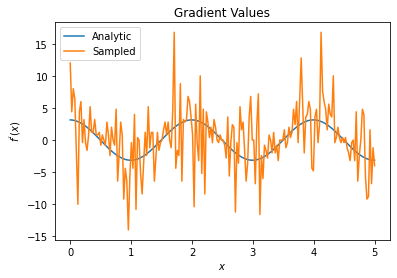

In [11]:
# Gradients are a much different story.
values_tensor = tf.convert_to_tensor(input_points)

with tf.GradientTape() as g:
    g.watch(values_tensor)
    exact_outputs = expectation_calculation(my_circuit,
                                            operators=pauli_x,
                                            symbol_names=['alpha'],
                                            symbol_values=values_tensor)
analytic_finite_diff_gradients = g.gradient(exact_outputs, values_tensor)

with tf.GradientTape() as g:
    g.watch(values_tensor)
    imperfect_outputs = sampled_expectation_calculation(
        my_circuit,
        operators=pauli_x,
        repetitions=500,
        symbol_names=['alpha'],
        symbol_values=values_tensor)
sampled_finite_diff_gradients = g.gradient(imperfect_outputs, values_tensor)

plt.title('Gradient Values')
plt.xlabel('$x$')
plt.ylabel('$f^{\'}(x)$')
plt.plot(input_points, analytic_finite_diff_gradients, label='Analytic')
plt.plot(input_points, sampled_finite_diff_gradients, label='Sampled')
plt.legend()

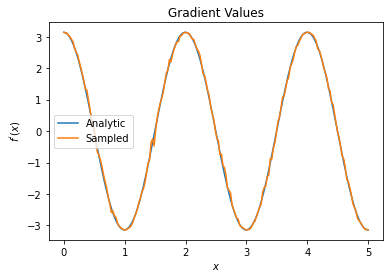

In [12]:
# A smarter differentiation scheme.
gradient_safe_sampled_expectation = tfq.layers.SampledExpectation(
    differentiator=tfq.differentiators.ParameterShift())

with tf.GradientTape() as g:
    g.watch(values_tensor)
    imperfect_outputs = gradient_safe_sampled_expectation(
        my_circuit,
        operators=pauli_x,
        repetitions=500,
        symbol_names=['alpha'],
        symbol_values=values_tensor)

sampled_param_shift_gradients = g.gradient(imperfect_outputs, values_tensor)

plt.title('Gradient Values')
plt.xlabel('$x$')
plt.ylabel('$f^{\'}(x)$')
plt.plot(input_points, analytic_finite_diff_gradients, label='Analytic')
plt.plot(input_points, sampled_param_shift_gradients, label='Sampled')
plt.legend()

In [13]:
pauli_z = cirq.Z(qubit)
pauli_z

Z((0, 0))

In [14]:
test_value = 0.

print('Finite difference:', my_grad(pauli_z, test_value))
print('Sin formula:      ', -np.pi * np.sin(np.pi * test_value))

Finite difference: -0.04934072494506836
Sin formula:       -0.0


In [15]:
sum_of_outputs = tfq.layers.Expectation(
    differentiator=tfq.differentiators.ForwardDifference(grid_spacing=0.01))

sum_of_outputs(my_circuit,
               operators=[pauli_x, pauli_z],
               symbol_names=['alpha'],
               symbol_values=[[test_value]])

<tf.Tensor: shape=(1, 2), dtype=float32, numpy=array([[0., 1.]], dtype=float32)>

In [16]:
test_value_tensor = tf.convert_to_tensor([[test_value]])

with tf.GradientTape() as g:
    g.watch(test_value_tensor)
    outputs = sum_of_outputs(my_circuit,
                             operators=[pauli_x, pauli_z],
                             symbol_names=['alpha'],
                             symbol_values=test_value_tensor)

sum_of_gradients = g.gradient(outputs, test_value_tensor)

print(my_grad(pauli_x, test_value) + my_grad(pauli_z, test_value))
print(sum_of_gradients.numpy())

3.0917350202798843
[[3.0917215]]


In [0]:
class MyDifferentiator(tfq.differentiators.Differentiator):
    """A Toy differentiator for <Y^alpha | X |Y^alpha>."""

    def __init__(self):
        pass

    @tf.function
    def _compute_gradient(self, symbol_values):
        """Compute the gradient based on symbol_values."""

        # f(x) = sin(pi * x)
        # f'(x) = pi * cos(pi * x)
        return tf.cast(tf.cos(symbol_values * np.pi) * np.pi, tf.float32)

    @tf.function
    def differentiate_analytic(self, programs, symbol_names, symbol_values,
                               pauli_sums, forward_pass_vals, grad):
        """Specify how to differentiate a circuit with analytical expectation.

        This is called at graph runtime by TensorFlow. `differentiate_analytic`
        should calculate the gradient of a batch of circuits and return it
        formatted as indicated below. See
        `tfq.differentiators.ForwardDifference` for an example.

        Args:
            programs: `tf.Tensor` of strings with shape [batch_size] containing
                the string representations of the circuits to be executed.
            symbol_names: `tf.Tensor` of strings with shape [n_params], which
                is used to specify the order in which the values in
                `symbol_values` should be placed inside of the circuits in
                `programs`.
            symbol_values: `tf.Tensor` of real numbers with shape
                [batch_size, n_params] specifying parameter values to resolve
                into the circuits specified by programs, following the ordering
                dictated by `symbol_names`.
            pauli_sums: `tf.Tensor` of strings with shape [batch_size, n_ops]
                containing the string representation of the operators that will
                be used on all of the circuits in the expectation calculations.
            forward_pass_vals: `tf.Tensor` of real numbers with shape
                [batch_size, n_ops] containing the output of the forward pass
                through the op you are differentiating.
            grad: `tf.Tensor` of real numbers with shape [batch_size, n_ops]
                representing the gradient backpropagated to the output of the
                op you are differentiating through.

        Returns:
            A `tf.Tensor` with the same shape as `symbol_values` representing
            the gradient backpropagated to the `symbol_values` input of the op
            you are differentiating through.
        """

        # Computing gradients just based off of symbol_values.
        return self._compute_gradient(symbol_values) * grad

    @tf.function
    def differentiate_sampled(self, programs, symbol_names, symbol_values,
                              pauli_sums, num_samples, forward_pass_vals, grad):
        """Specify how to differentiate a circuit with sampled expectation.

        This is called at graph runtime by TensorFlow. `differentiate_sampled`
        should calculate the gradient of a batch of circuits and return it
        formatted as indicated below. See
        `tfq.differentiators.ForwardDifference` for an example.

        Args:
            programs: `tf.Tensor` of strings with shape [batch_size] containing
                the string representations of the circuits to be executed.
            symbol_names: `tf.Tensor` of strings with shape [n_params], which
                is used to specify the order in which the values in
                `symbol_values` should be placed inside of the circuits in
                `programs`.
            symbol_values: `tf.Tensor` of real numbers with shape
                [batch_size, n_params] specifying parameter values to resolve
                into the circuits specified by programs, following the ordering
                dictated by `symbol_names`.
            pauli_sums: `tf.Tensor` of strings with shape [batch_size, n_ops]
                containing the string representation of the operators that will
                be used on all of the circuits in the expectation calculations.
            num_samples: `tf.Tensor` of positive integers representing the
                number of samples per term in each term of pauli_sums used
                during the forward pass.
            forward_pass_vals: `tf.Tensor` of real numbers with shape
                [batch_size, n_ops] containing the output of the forward pass
                through the op you are differentiating.
            grad: `tf.Tensor` of real numbers with shape [batch_size, n_ops]
                representing the gradient backpropagated to the output of the
                op you are differentiating through.

        Returns:
            A `tf.Tensor` with the same shape as `symbol_values` representing
            the gradient backpropagated to the `symbol_values` input of the op
            you are differentiating through.
        """
        return self._compute_gradient(symbol_values) * grad

Text(0.5, 0, 'x')

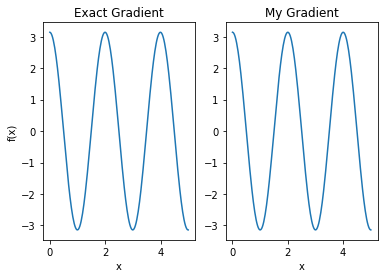

In [18]:
custom_dif = MyDifferentiator()
custom_grad_expectation = tfq.layers.Expectation(differentiator=custom_dif)

# Now let's get the gradients with finite diff.
with tf.GradientTape() as g:
    g.watch(values_tensor)
    exact_outputs = expectation_calculation(my_circuit,
                                            operators=[pauli_x],
                                            symbol_names=['alpha'],
                                            symbol_values=values_tensor)

analytic_finite_diff_gradients = g.gradient(exact_outputs, values_tensor)

# Now let's get the gradients with custom diff.
with tf.GradientTape() as g:
    g.watch(values_tensor)
    my_outputs = custom_grad_expectation(my_circuit,
                                         operators=[pauli_x],
                                         symbol_names=['alpha'],
                                         symbol_values=values_tensor)

my_gradients = g.gradient(my_outputs, values_tensor)

plt.subplot(1, 2, 1)
plt.title('Exact Gradient')
plt.plot(input_points, analytic_finite_diff_gradients.numpy())
plt.xlabel('x')
plt.ylabel('f(x)')
plt.subplot(1, 2, 2)
plt.title('My Gradient')
plt.plot(input_points, my_gradients.numpy())
plt.xlabel('x')

In [19]:
# Create a noisy sample based expectation op.
expectation_sampled = tfq.get_sampled_expectation_op(
    cirq.DensityMatrixSimulator(noise=cirq.depolarize(0.01)))

# Make it differentiable with your differentiator:
# Remember to refresh the differentiator before attaching the new op
custom_dif.refresh()
differentiable_op = custom_dif.generate_differentiable_op(
    sampled_op=expectation_sampled)

# Prep op inputs.
circuit_tensor = tfq.convert_to_tensor([my_circuit])
op_tensor = tfq.convert_to_tensor([[pauli_x]])
single_value = tf.convert_to_tensor([[my_alpha]])
num_samples_tensor = tf.convert_to_tensor([[1000]])

with tf.GradientTape() as g:
    g.watch(single_value)
    forward_output = differentiable_op(circuit_tensor, ['alpha'], single_value,
                                       op_tensor, num_samples_tensor)

my_gradients = g.gradient(forward_output, single_value)

print('---TFQ---')
print('Foward:  ', forward_output.numpy())
print('Gradient:', my_gradients.numpy())
print('---Original---')
print('Forward: ', my_expectation(pauli_x, my_alpha))
print('Gradient:', my_grad(pauli_x, my_alpha))

---TFQ---
Foward:   [[0.794]]
Gradient: [[1.8465817]]
---Original---
Forward:  0.80901700258255
Gradient: 1.8063604831695557
